In [1]:
# Complete Pipeline for CGL-PINN Training and Evaluation
# This notebook implements the full training and evaluation pipeline with all modifications

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime
from models import *
from utils import generate_video

np.random.seed(42)
torch.manual_seed(42)

print("Loading data...")
state = np.load("data/states_processed_cropped_finalized (2).npy")
myu_binarized = np.load("data/myus_binarized_processed_cropped_finalized (3).npy")
myu_original = np.load("data/myus_original_non_binarized.npy")

print("State shape:", state.shape, state.dtype)
print("Binarized μ shape:", myu_binarized.shape, myu_binarized.dtype)
print("Original μ shape:", myu_original.shape, myu_original.dtype)

A_r_data = state.real
A_i_data = state.imag

Nt, Nx, Ny = state.shape
dt, dx, dy = 0.05, 0.3, 0.3

Nx_down, Ny_down = 12, 16
degrade_x = Nx // Nx_down
degrade_y = Ny // Ny_down
degrade_t = 150

print(f"Domain size: Nt={Nt}, Nx={Nx}, Ny={Ny}")
print(f"Downsampled μ size: Nx_down={Nx_down}, Ny_down={Ny_down}")
print(f"Degradation factors: degrade_x={degrade_x}, degrade_y={degrade_y}, degrade_t={degrade_t}")

n_data = 30000
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

t_vals = np.arange(Nt) * dt
x_vals = np.arange(Nx) * dx
y_vals = np.arange(Ny) * dy

t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

x_data_t = torch.tensor(x_data_np, dtype=torch.float32, device=device).view(-1, 1)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32, device=device).view(-1, 1)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32, device=device).view(-1, 1)

n_coll = 30000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

output_base_dir = "./results"
os.makedirs(output_base_dir, exist_ok=True)

Loading data...
State shape: (1500, 360, 637) complex64
Binarized μ shape: (1500, 360, 637) uint8
Original μ shape: (1500, 360, 647) float64
Domain size: Nt=1500, Nx=360, Ny=637
Downsampled μ size: Nx_down=12, Ny_down=16
Degradation factors: degrade_x=30, degrade_y=39, degrade_t=150
Using device: cuda


In [2]:
# Model hyperparameters
model_name = "TimeBlockV2_Final"
output_dir = output_base_dir
n_epochs = 10000  # Full training would be longer, adjust as needed
batch_size = 2048
learning_rate = 1e-3
weight_pde = 0.1
validation_split = 0.2
val_freq = 50
video_freq = 5000  # Generate videos more frequently during training

# Initialize model
model = NPINN_PRO_MAX_TIMEBLOCK_V2(
    layers=[3, 128, 256, 256, 128, 2],  # Deeper and wider architecture
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=weight_pde,
    device=device,
    degrade_t=degrade_t,
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {total_params} total parameters, {trainable_params} trainable")

Model initialized with 236546 total parameters, 236546 trainable


In [3]:
print(f"Starting training for {n_epochs} epochs...")
model.train_model(
    x_data=x_data_t,
    y_data=y_data_t,
    t_data=t_data_t,
    A_r_data=Ar_data_t,
    A_i_data=Ai_data_t,
    x_eqs=x_eqs_t,
    y_eqs=y_eqs_t,
    t_eqs=t_eqs_t,
    n_epochs=n_epochs,
    lr=learning_rate,
    batch_size=batch_size,
    model_name=model_name,
    output_dir=output_dir,
    video_freq=video_freq,
    state_exp=state,
    myu_full_exp=myu_binarized,
    myu_full_original_exp=myu_original,  # Add the non-binarized μ data
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device=device,
    validation_split=validation_split,
    val_freq=val_freq
)

model_folder = os.path.join(output_dir, model_name)
best_model_path = os.path.join(model_folder, f"{model_name}_best.pt")
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Loaded best model from {best_model_path}")

print("Generating final evaluation video...")
video_output_path = os.path.join(model_folder, "final_evaluation")
os.makedirs(video_output_path, exist_ok=True)

generate_video(
    state=state,
    mu_full=myu_binarized,
    mu_full_original=myu_original,
    model=model,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device=device,
    output_path=video_output_path,
    video_file_name=f"{model_name}_final_evaluation.mp4",
    enable_vmin_vmax=True
)
print(f"Final evaluation video saved to {video_output_path}")

Starting training for 10000 epochs...
Starting training with 24000 training samples and 6000 validation samples
Epoch 0: New best model saved (val_loss=1.2529e+00)
Epoch 0: Train [total=2.3439e+00, data=1.7121e+00, PDE=6.3168e+00] | Val [total=1.2529e+00, data=1.2269e+00, PDE=2.5968e-01] | LR=4.000237e-05
Epoch 50: New best model saved (val_loss=5.4148e-01)
Epoch 100: New best model saved (val_loss=5.1419e-01)
Epoch 100: Train [total=4.7840e-01, data=4.6433e-01, PDE=1.4023e-01] | Val [total=5.1419e-01, data=4.9882e-01, PDE=1.5364e-01] | LR=6.396507e-05
Epoch 150: New best model saved (val_loss=4.9445e-01)
Epoch 200: New best model saved (val_loss=4.8908e-01)
Epoch 200: Train [total=4.2743e-01, data=4.1208e-01, PDE=1.5291e-01] | Val [total=4.8908e-01, data=4.7144e-01, PDE=1.7642e-01] | LR=1.325750e-04
Epoch 250: New best model saved (val_loss=4.7586e-01)
Epoch 300: New best model saved (val_loss=4.6427e-01)
Epoch 300: Train [total=3.9918e-01, data=3.8330e-01, PDE=1.5797e-01] | Val [tota

C:\Users\meloy\AppData\Local\Temp\ipykernel_7352\2797283513.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Resizing mu_expanded from (360, 624) to (360, 637)
Resizing mu_expanded_original from (360, 624) to (360, 647)


Generating frames: 100%|██████████| 1500/1500 [01:13<00:00, 20.28it/s]
C:\Users\meloy\Desktop\gl_pinn-final\Paper\utils.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
Creating video: 100%|██████████| 1500/1500 [14:32<00:00,  1.72it/s]


Video saved at: ./results\TimeBlockV2_Final\final_evaluation\TimeBlockV2_Final_final_evaluation.mp4
Final evaluation video saved to ./results\TimeBlockV2_Final\final_evaluation


Creating loss visualization...


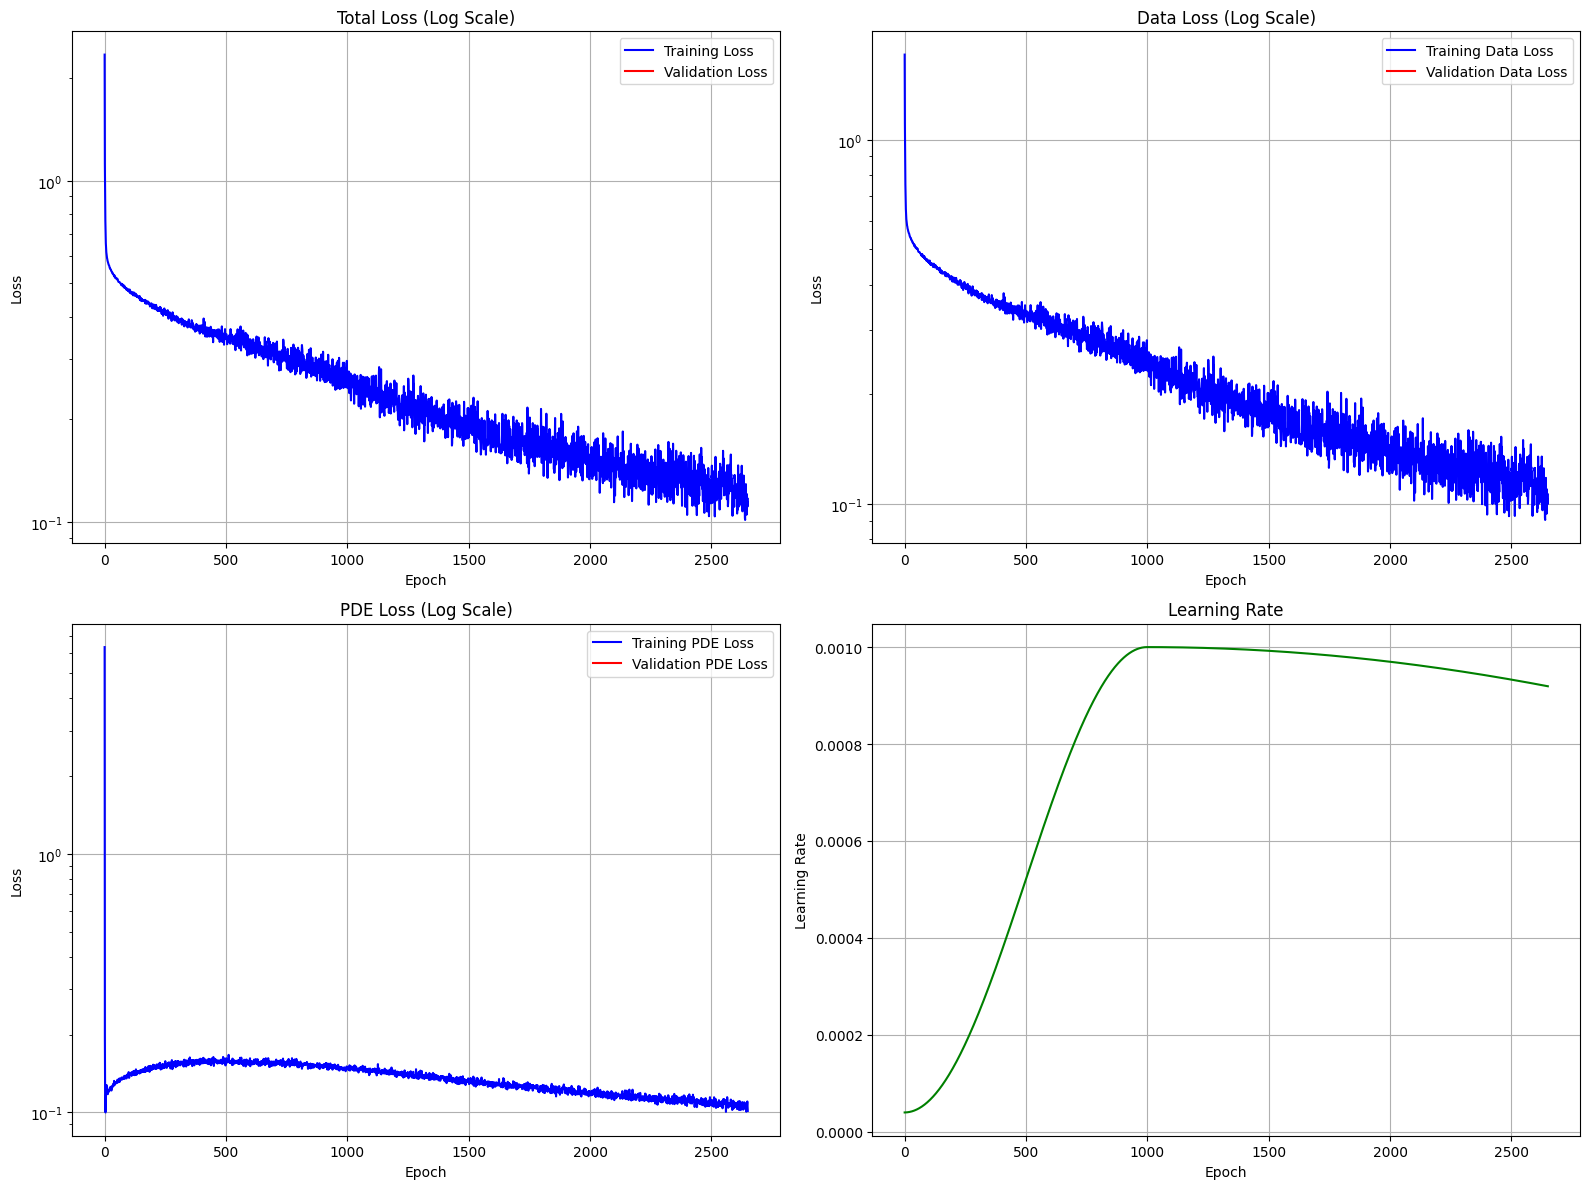

Visualizing a sample prediction...


ValueError: operands could not be broadcast together with shapes (360,637) (637,360) 

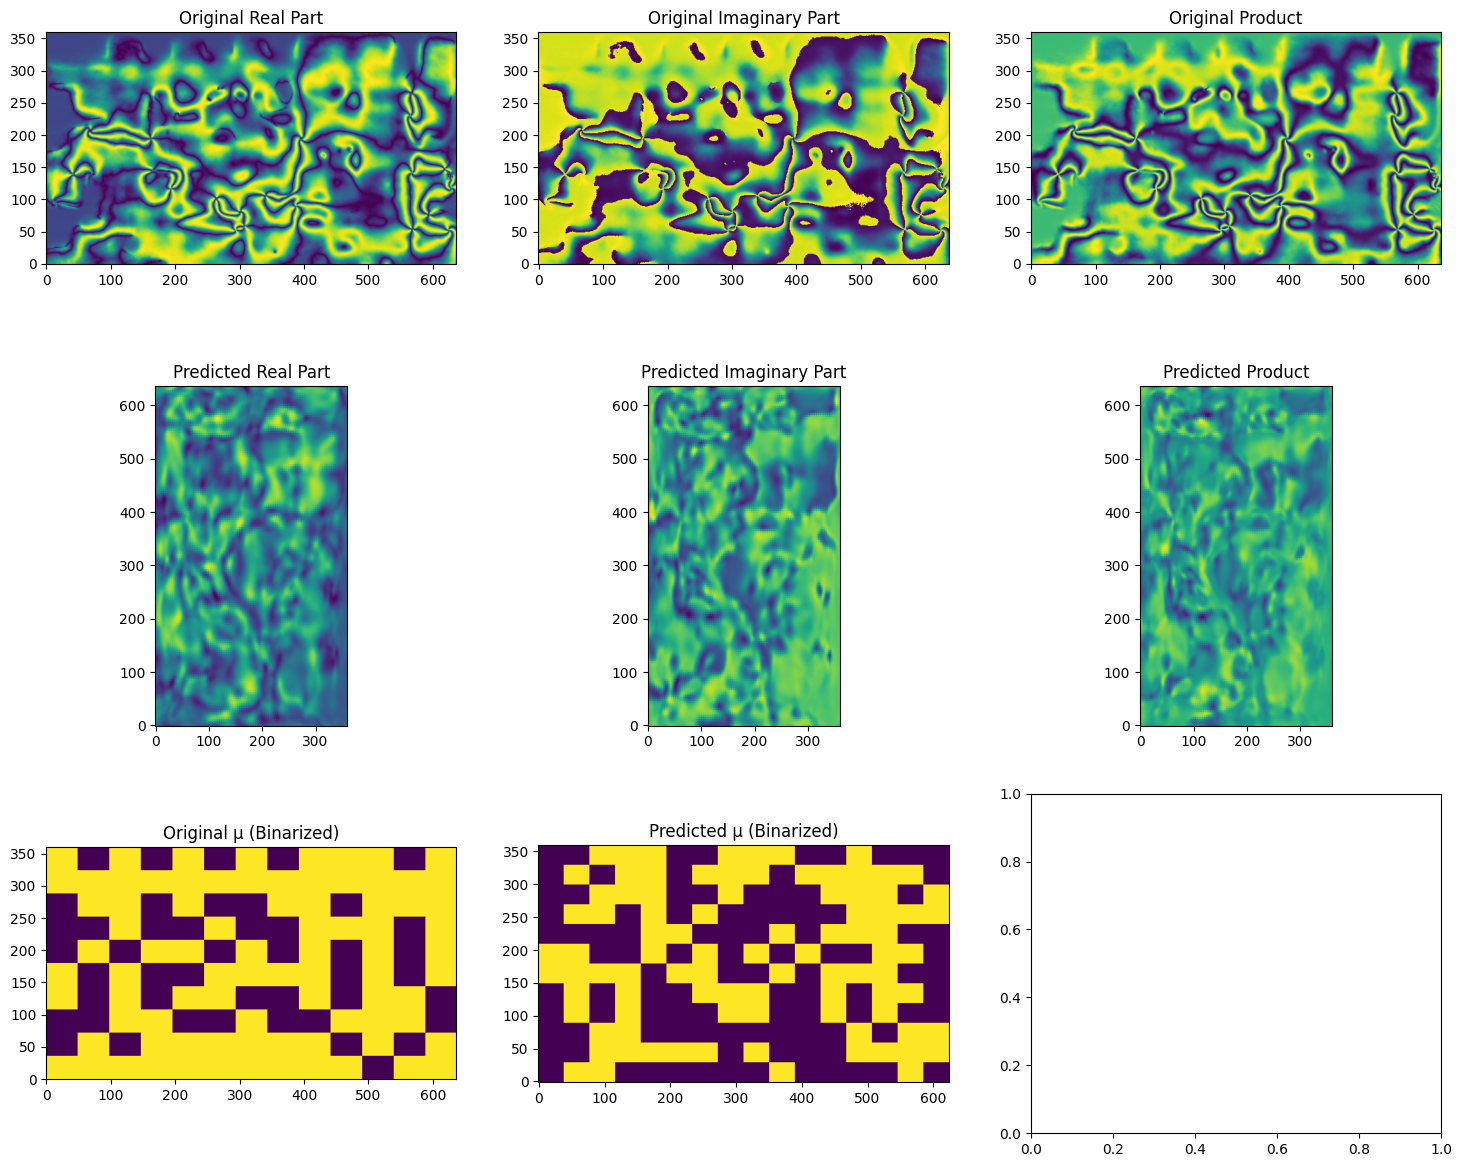

In [4]:
import pandas as pd

print("Creating loss visualization...")
losses_df = pd.read_csv(os.path.join(model_folder, f"{model_name}_losses.csv"))

# Plot all metrics
plt.figure(figsize=(16, 12))

# Total loss (log scale)
plt.subplot(2, 2, 1)
plt.semilogy(losses_df['epoch'], losses_df['train_total_loss'], 'b-', label='Training Loss')
plt.semilogy(losses_df['epoch'], losses_df['val_total_loss'], 'r-', label='Validation Loss')
plt.title('Total Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Data loss (log scale)
plt.subplot(2, 2, 2)
plt.semilogy(losses_df['epoch'], losses_df['train_data_loss'], 'b-', label='Training Data Loss')
plt.semilogy(losses_df['epoch'], losses_df['val_data_loss'], 'r-', label='Validation Data Loss')
plt.title('Data Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# PDE loss (log scale)
plt.subplot(2, 2, 3)
plt.semilogy(losses_df['epoch'], losses_df['train_pde_loss'], 'b-', label='Training PDE Loss')
plt.semilogy(losses_df['epoch'], losses_df['val_pde_loss'], 'r-', label='Validation PDE Loss')
plt.title('PDE Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Learning rate
plt.subplot(2, 2, 4)
plt.plot(losses_df['epoch'], losses_df['lr'], 'g-')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(model_folder, f"{model_name}_loss_curves.png"), dpi=300)
plt.show()

print("Visualizing a sample prediction...")
# Choose a random time point
sample_time_idx = np.random.randint(0, Nt)
sample_time = t_vals[sample_time_idx]

# Create a meshgrid for this time point
X, Y = np.meshgrid(x_vals, y_vals)
XX = X.ravel()
YY = Y.ravel()
TT = np.full_like(XX, sample_time)

# Get model predictions
x_test_t = torch.tensor(XX, dtype=torch.float32, device=device).view(-1, 1)
y_test_t = torch.tensor(YY, dtype=torch.float32, device=device).view(-1, 1)
t_test_t = torch.tensor(TT, dtype=torch.float32, device=device).view(-1, 1)

with torch.no_grad():
    A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
    A_r_pred_2d = A_r_pred.reshape(X.shape)
    A_i_pred_2d = A_i_pred.reshape(X.shape)

# Get μ predictions
mu_pred = model.expand_myu_full(do_binarize=True, scale_255=False)
mu_pred_original = model.expand_myu_full(do_binarize=False, scale_255=False)

# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Original data
axes[0, 0].imshow(state[sample_time_idx].real, cmap='viridis', origin='lower')
axes[0, 0].set_title("Original Real Part")

axes[0, 1].imshow(state[sample_time_idx].imag, cmap='viridis', origin='lower')
axes[0, 1].set_title("Original Imaginary Part")

axes[0, 2].imshow(state[sample_time_idx].real * state[sample_time_idx].imag, cmap='viridis', origin='lower')
axes[0, 2].set_title("Original Product")

# Predicted data
axes[1, 0].imshow(A_r_pred_2d, cmap='viridis', origin='lower')
axes[1, 0].set_title("Predicted Real Part")

axes[1, 1].imshow(A_i_pred_2d, cmap='viridis', origin='lower')
axes[1, 1].set_title("Predicted Imaginary Part")

axes[1, 2].imshow(A_r_pred_2d * A_i_pred_2d, cmap='viridis', origin='lower')
axes[1, 2].set_title("Predicted Product")

# μ data
axes[2, 0].imshow(myu_binarized[sample_time_idx], cmap='viridis', origin='lower')
axes[2, 0].set_title("Original μ (Binarized)")

axes[2, 1].imshow(mu_pred[sample_time_idx], cmap='viridis', origin='lower')
axes[2, 1].set_title("Predicted μ (Binarized)")

# Error
abs_diff = np.abs(state[sample_time_idx].real * state[sample_time_idx].imag - A_r_pred_2d * A_i_pred_2d)
axes[2, 2].imshow(abs_diff, cmap='hot', origin='lower')
axes[2, 2].set_title("Absolute Difference")

plt.tight_layout()
plt.savefig(os.path.join(model_folder, f"{model_name}_sample_prediction.png"), dpi=300)
plt.show()

print("Pipeline completed successfully!")

# ==== Additional Evaluation (Optional) ====

print("Computing performance metrics across the domain...")

# Initialize arrays for MSE, MAE, and SSIM
mse_values = []
mae_values = []
relative_error_values = []

# Loop over time points (you can adjust the step to evaluate fewer points)
time_step = 1  # Evaluate every time point
for i in range(0, Nt, time_step):
    print(f"Evaluating time point {i}/{Nt}", end='\r')

    # Create a meshgrid for this time point
    X, Y = np.meshgrid(x_vals, y_vals)
    XX = X.ravel()
    YY = Y.ravel()
    TT = np.full_like(XX, t_vals[i])

    # Get model predictions
    x_test_t = torch.tensor(XX, dtype=torch.float32, device=device).view(-1, 1)
    y_test_t = torch.tensor(YY, dtype=torch.float32, device=device).view(-1, 1)
    t_test_t = torch.tensor(TT, dtype=torch.float32, device=device).view(-1, 1)

    with torch.no_grad():
        A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
        A_r_pred_2d = A_r_pred.reshape(X.shape)
        A_i_pred_2d = A_i_pred.reshape(X.shape)

    # Compute the product
    pred_prod = A_r_pred_2d * A_i_pred_2d
    true_prod = state[i].real * state[i].imag

    # Ensure consistent shapes
    if pred_prod.shape != true_prod.shape:
        pred_prod = pred_prod.T

    # Compute metrics
    mse = np.mean((true_prod - pred_prod) ** 2)
    mae = np.mean(np.abs(true_prod - pred_prod))

    # Compute relative error
    eps = 1e-8  # Small constant to avoid division by zero
    rel_error = np.mean(np.abs(true_prod - pred_prod) / (np.abs(true_prod) + eps))

    mse_values.append(mse)
    mae_values.append(mae)
    relative_error_values.append(rel_error)

print("\nMetrics computation complete")

# Average metrics
avg_mse = np.mean(mse_values)
avg_mae = np.mean(mae_values)
avg_rel_error = np.mean(relative_error_values)

print(f"Average MSE: {avg_mse:.6f}")
print(f"Average MAE: {avg_mae:.6f}")
print(f"Average Relative Error: {avg_rel_error:.6f}")

# Plot metrics over time
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(np.arange(0, Nt, time_step), mse_values)
plt.title('MSE over Time')
plt.xlabel('Time Index')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(np.arange(0, Nt, time_step), mae_values)
plt.title('MAE over Time')
plt.xlabel('Time Index')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(np.arange(0, Nt, time_step), relative_error_values)
plt.title('Relative Error over Time')
plt.xlabel('Time Index')
plt.ylabel('Relative Error')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(model_folder, f"{model_name}_metrics_over_time.png"), dpi=300)
plt.show()

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'time_index': np.arange(0, Nt, time_step),
    'mse': mse_values,
    'mae': mae_values,
    'relative_error': relative_error_values
})
metrics_df.to_csv(os.path.join(model_folder, f"{model_name}_evaluation_metrics.csv"), index=False)

print("Evaluation complete. All files saved successfully.")